In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import h5py
import glob
import copy
import datetime as dt

In [2]:
### Inicio de la parte que requiere modificacion por el usuario

# direccion de los archivos HDF de entrada y salidda 
# nombre semilla de los archivos (e.g. mexico_oco3_target, o mexico_oco3_early)
path_hdfin = "f:\\jupyter\\oco3_mexico_city\\mexico\\"
path_hdfout = "f:\\jupyter\\oco3_mexico_city\\mexico\\"
seedname = 'mexico_oco3_target_'

# nombre en el archivo HDF de las variables de latitud (y), longitud (x), y de interes (z)
# aqui se incluye el nombre de POSIX (tepoch) por si se llegase a cambiar
# NOTA, estos valores tienen que ser escalares, vectores (e.g. columna de co2) van a generar error
latname = '/latitude'
lonname = '/longitude'
zname = '/xco2'
epochname = 'tepoch'

# inicializacion de las condiciones : año, mes (o meses), punto de interes (lat y lon), tamaño de grid deseado
location_name = 'Location Name'
years = [2020]
months = np.arange(1,7)                           # np.arange(n,m) genera un arreglo con primer elemento n y ultimo m-1
latpoint = 19.5                                   # latitud del punto de interes
lonpoint = -98.5                                  # longitud del punto de interes
gridsize = 0.6                                    # tamanyo del grid en fraccion de grados

### Fin de la parte que requiere moddificacion por el usuario

In [3]:
# Esta seccion genera una matriz 3x3x2 con las coordenadas +- 1 grado de latitud y longitud de las seccion del punto de interes
# e.g para 19N-98W genera un grid 9x9 que va de 20N-99W a 18N-97W

# Dependiendo del punto de interes y del tamanyo del area en fraccion de grados; una, varias, o todas las celdas del grid 9x9 
# entraran en los datos que se buscan

# Se genera un filtro para construir las diferentes etiquetas xN-yW para accesar a las carpetas del archivo HDF y obtener los
# dadtos

# latitud y longitud maxima y minima
grid_max_lat = latpoint + gridsize
grid_min_lat = latpoint - gridsize
grid_max_lon = lonpoint - gridsize
grid_min_lon = lonpoint + gridsize

# convertir los float a integer
gridlat = int(latpoint)
gridlon = int(lonpoint)
gridmaxlat = int(grid_max_lat)
gridminlat = int(grid_min_lat)
gridmaxlon = int(grid_max_lon)
gridminlon = int(grid_min_lon)

# vectores de latitud y longitud
latvector = [gridlat-1,gridlat,gridlat+1]
lonvector = [gridlon+1,gridlon,gridlon-1]

# matriz 3x3x2 con los grids individuales de latitud y longitud
# creada a mano, quiza haya una forma de hacerla menos explicita?
grid9x9 = np.array([[[latvector[2],lonvector[2]],[latvector[2],lonvector[1]],[latvector[2],lonvector[0]]], \
                   [[latvector[1],lonvector[2]],[latvector[1],lonvector[1]],[latvector[1],lonvector[0]]], \
                   [[latvector[0],lonvector[2]],[latvector[0],lonvector[1]],[latvector[0],lonvector[0]]]])

# filtro para seleccionar los grids que cubre el punto central con el tamanyo de grid
mask = (grid9x9[:,:,0] >= gridminlat) & (grid9x9[:,:,0] <= gridmaxlat) & (grid9x9[:,:,1] <= gridminlon) & (grid9x9[:,:,1] >= gridmaxlon)



In [4]:
# contadores inevitables
cont = 0                              # para saber que hacer si la matriz de datos ya se creo o no

In [5]:
# testing
print(gridmaxlat,gridminlat,gridmaxlon,gridminlon)

print(mask)

print(grid9x9[mask])

for row in grid9x9[mask]:
    gridname = '%iN%iW' % (int(row[0]),int(row[1]))
    print(gridname)

20 18 -99 -97
[[ True  True  True]
 [ True  True  True]
 [ True  True  True]]
[[ 20 -99]
 [ 20 -98]
 [ 20 -97]
 [ 19 -99]
 [ 19 -98]
 [ 19 -97]
 [ 18 -99]
 [ 18 -98]
 [ 18 -97]]
20N-99W
20N-98W
20N-97W
19N-99W
19N-98W
19N-97W
18N-99W
18N-98W
18N-97W


In [6]:
# algoritmo para generar la matriz de todos los datos en el grid 1x1 de los diferentes hdf
# este arrojara la matriz que despues se filtrara para hacer las series de tiempo
for year in years:
    for month in months:
        h5name = "%i%02i.h5" %(year,month)
        h5file = path_hdfin + seedname + h5name
        print('Intentando con el archivo: ', h5file)
        
        try:
            data = h5py.File(h5file,'r')
            
            for coords in grid9x9[mask]:
                
                gridname = '%iN%iW' % (coords[0],coords[1])
                #print(gridname)
                
                try:
                    # expande los vectores para concatenar y toma los datos del grid en donde esta el punto
                    # genera un objeto datetime a partir del valor de tepoch
                    lat = np.expand_dims(data[gridname][latname],axis=1)
                    lon = np.expand_dims(data[gridname][lonname],axis=1)
                    zvar = np.expand_dims(data[gridname][zname],axis=1)
                    t_epoch = data[gridname][epochname]
                    time = np.array([dt.datetime.utcfromtimestamp(ele) for ele in t_epoch])
                    time = np.expand_dims(time,axis=1)
        
                    # concatena los 4 vectores Nx1 en una matriz temporal Nx4
                    mat=np.concatenate((time,lat,lon,zvar),axis=1)
        
        
                    if cont == 0:
                        # copia la matriz temporal en una permanente
                        # esto solo se debe usar si no existe ya la matriz permanente
                        datos=copy.copy(mat)
            
                    else:
                        # concatena los datos de la matriz temporal en la permanente
                        # esto solo se debe usar si ya existe la matriz permanente
                        datos=np.concatenate((mat,datos),axis=0)
                    
                    cont = cont + 1
                
                except:
                    print('no hay datos para %iN%iW' %(coords[0],coords[1]))
                    continue
                           
            data.close()
                    
        except:
            print('no hay datos para %i-%02i' %(year,month))
            continue
    

Intentando con el archivo:  f:\jupyter\oco3_mexico_city\mexico\mexico_oco3_target_202001.h5
no hay datos para 2020-01
Intentando con el archivo:  f:\jupyter\oco3_mexico_city\mexico\mexico_oco3_target_202002.h5
no hay datos para 20N-99W
no hay datos para 20N-98W
no hay datos para 20N-97W
no hay datos para 19N-97W
no hay datos para 18N-97W
Intentando con el archivo:  f:\jupyter\oco3_mexico_city\mexico\mexico_oco3_target_202003.h5
no hay datos para 20N-98W
no hay datos para 20N-97W
no hay datos para 19N-97W
no hay datos para 18N-97W
Intentando con el archivo:  f:\jupyter\oco3_mexico_city\mexico\mexico_oco3_target_202004.h5
no hay datos para 20N-97W
no hay datos para 19N-97W
no hay datos para 18N-98W
no hay datos para 18N-97W
Intentando con el archivo:  f:\jupyter\oco3_mexico_city\mexico\mexico_oco3_target_202005.h5
no hay datos para 20N-97W
no hay datos para 19N-97W
no hay datos para 18N-97W
Intentando con el archivo:  f:\jupyter\oco3_mexico_city\mexico\mexico_oco3_target_202006.h5
no hay

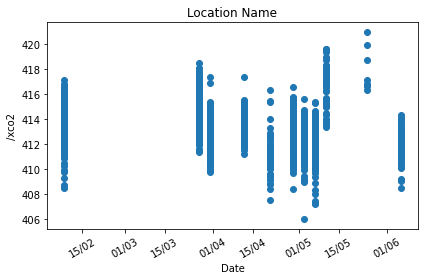

In [7]:
# condiciones para reducir el tamaño del grid alrededor del punto seleccionado y obtener datos dentro ded ese nuevo grid

gridcond = ((datos[:,1] <= grid_max_lat) & (datos[:,1] >= grid_min_lat) & (datos[:,2] <= grid_min_lon) & (datos[:,2] >= grid_max_lon))
#print(gridcond) 

# grafica una serie de tiempo sencilla con los datos filtrados por las condiciones
 
locator = mdates.AutoDateLocator()
formatter = mdates.DateFormatter('%d/%m')
#leftlim = 
#rightlim =
fig, ax = plt.subplots()
plt.plot_date(datos[:,0][gridcond],datos[:,3][gridcond]) 
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
#ax.xaxis.set_xlim(left=)
plt.xlabel('Date')
plt.ylabel(zname)
plt.title(location_name)
plt.tight_layout() 
plt.show()

In [14]:
# testing
print(datos[:,0])
print(datos[:,1])
print(datos[:,2])

[datetime.datetime(2020, 6, 5, 17, 41, 9, 950032)
 datetime.datetime(2020, 6, 5, 17, 41, 10, 283365)
 datetime.datetime(2020, 6, 5, 17, 41, 11, 751698) ...
 datetime.datetime(2020, 2, 8, 16, 29, 42, 616698)
 datetime.datetime(2020, 2, 8, 16, 29, 42, 643698)
 datetime.datetime(2020, 2, 8, 16, 29, 42, 896032)]
[18.213348388671875 18.229597091674805 18.415998458862305 ...
 19.426082611083984 19.43975257873535 19.414581298828125]
[-98.8134536743164 -98.80001831054688 -98.74687194824219 ...
 -99.0334701538086 -99.04315948486328 -99.00028228759766]
